# Distribution of gene expression levels

The goal is to estimate quantiles that characterize how a population of promoter sequences affects gene expression. Vaishnav et al. (1) recently trained a state-of-the-art transformer model to predict the expression level of a particular gene induced by a promoter sequence. They used the model's predictions to study the effects of promoters; for example, by assessing how quantiles of predicted expression levels differ between different populations of promoters. This notebook shows how the predictions used by Vaishnav et al. can be leveraged to estimate different quantiles of gene expression levels induced by native yeast promoters with higher statistical power.

1. E. D. Vaishnav, C. G. de Boer, J. Molinet, M. Yassour, L. Fan, X. Adiconis, D. A. Thompson, J. Z. Levin, F. A. Cubillos, A. Regev, The evolution, evolvability and engineering of gene regulatory DNA. Nature 603(7901), 455–463 (2022).

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_quantile_ci, classical_quantile_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the gene expression data set

Load the data. The data set contains gold-standard labels for the gene expression level (```Y```) and corresponding predicted labels based on the transformer model (```Yhat```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "gene_expression")
Y_total = data["Y"]
Yhat_total = data["Yhat"]

Dataset gene_expression not found at location ./data/; downloading now...


Downloading...
From: https://drive.google.com/uc?id=17PwlvAAKeBYGLXPz9L2LVnNJ66XjuyZd
To: /Users/angelopoulos/Code/working/ppi_py/examples/data/gene_expression.npz
100%|██████████| 979k/979k [00:00<00:00, 1.22MB/s]


### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand (25%, 50%, or 75% quantile).

In [3]:
alpha = 0.05
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 5).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 100

# True quantiles (computed on all data)
true_quantile_q25 = np.quantile(Y_total, 0.25)
true_quantile_q50 = np.quantile(Y_total, 0.5)
true_quantile_q75 = np.quantile(Y_total, 0.75)

q = 0.5  # Target problem is inference on the median

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_quantile_ci(_Y, _Yhat, _Yhat_unlabeled, q, alpha=alpha)

        # Classical interval
        classical_ci = classical_quantile_ci(_Y, q, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_quantile_ci(Yhat_total, q, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0],
                "upper": imputed_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [17:53<00:00, 214.64s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

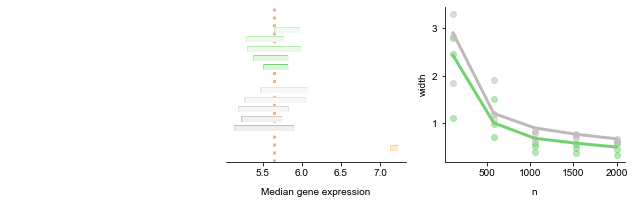

In [5]:
make_plots(
    df,
    "./plots/gene_expression.pdf",
    intervals_xlabel="Median gene expression",
    true_theta=true_quantile_q50,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \text{median gene expression} \leq 5$.

In [6]:
# Find n such that we reject H0: gene expression < 5 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_quantile_ci(_Y, _Yhat, _Yhat_unlabeled, q, alpha=alpha)
        if ppi_ci[0] > 5:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_quantile_ci(_Y, q, alpha=alpha)

        if classical_ci[0] > 5:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=10))
n_classical = int(brentq(_to_invert_classical, 100, 2000, xtol=10))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=667 labeled data points to reject the null.
The classical test requires n=997 labeled data points to reject the null.
